LunarLander: training PPO without wind then pausing training to add it helped

In [85]:
from gymnasium.wrappers import Autoreset, TimeAwareObservation
from collections import defaultdict, deque
from IPython.display import clear_output
import matplotlib.pyplot as plt
import gymnasium as gym
import numpy as np
import random
import wandb
import time
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Categorical

In [86]:
class ActorCritic(nn.Module):
    def __init__(self, n_in, n_out):
        super().__init__()
        self.fc1 = nn.Linear(n_in, 64)
        self.fc2 = nn.Linear(64, 64)
        self.g1 = nn.SiLU()
        self.g2 = nn.SiLU()
        self.policy_head = nn.Linear(64, n_out)
        self.value_head = nn.Linear(64, 1)
        
        nn.init.orthogonal_(self.fc1.weight, gain=torch.nn.init.calculate_gain('relu'))  # 'relu' gain = sqrt(2)
        nn.init.orthogonal_(self.fc2.weight, gain=torch.nn.init.calculate_gain('relu'))
        nn.init.orthogonal_(self.policy_head.weight, gain=0.01)  # uniform policy
        nn.init.orthogonal_(self.value_head.weight, gain=1.0)
        
        nn.init.constant_(self.fc1.bias, 0.0)
        nn.init.constant_(self.fc2.bias, 0.0)
        nn.init.constant_(self.policy_head.bias, 0.0)
        nn.init.constant_(self.value_head.bias, 0.0)

    def value_only(self, x):
        x = self.g1(self.fc1(x))
        x = self.g2(self.fc2(x))
        value = self.value_head(x)
        return value

    def forward(self, x):
        x = self.g1(self.fc1(x))
        x = self.g2(self.fc2(x))
        logits = self.policy_head(x)
        value = self.value_head(x)
        return logits, value

    def sample(self, state, stochastic=True):
        logits, value = self.forward(state)
        dist = Categorical(logits=logits)
        if stochastic:
            action = dist.sample()
        else:
            action = torch.argmax(logits, dim=-1)
        log_prob = dist.log_prob(action)
        return action, log_prob, value

In [198]:
env_name = 'LunarLander-v3'
def make_env(render_mode=None):
    env = gym.make(env_name, render_mode=render_mode, max_episode_steps=500, enable_wind=True)
    # env = TimeAwareObservation(env)
    env = Autoreset(env)  # TimeAwareObservation before Autoreset or else timestep tracking will be erroneous!!
    return env

In [162]:
def scope():  # check env is set up correctly
    e = make_env()
    e.reset()
    for i in range(500):
        if i % 10 == 0:
            clear_output(wait=True)
        s, r, term, trunc, _ = e.step(0)
        print('iter', i, torch.as_tensor(s, dtype=torch.float))
        if term or trunc:
            sout = ''
            if term: sout += 'terminated'
            if trunc: sout += 'truncated'  # truncates at max_episode_steps
            print(sout)
    e.close()
scope()

iter 490 tensor([ 0.2515,  0.3472,  0.5087, -1.6000, -0.2842, -0.1135,  0.0000,  0.0000])
iter 491 tensor([ 0.2566,  0.3106,  0.5087, -1.6266, -0.2899, -0.1135,  0.0000,  0.0000])
iter 492 tensor([ 0.2616,  0.2734,  0.5087, -1.6533, -0.2956, -0.1135,  0.0000,  0.0000])
iter 493 tensor([ 0.2666,  0.2356,  0.5087, -1.6800, -0.3013, -0.1135,  0.0000,  0.0000])
iter 494 tensor([ 0.2717,  0.1973,  0.5087, -1.7066, -0.3070, -0.1135,  0.0000,  0.0000])
iter 495 tensor([ 0.2767,  0.1583,  0.5087, -1.7333, -0.3126, -0.1135,  0.0000,  0.0000])
iter 496 tensor([ 0.2817,  0.1187,  0.5087, -1.7600, -0.3183, -0.1135,  0.0000,  0.0000])
iter 497 tensor([ 0.2868,  0.0786,  0.5087, -1.7867, -0.3240, -0.1135,  1.0000,  0.0000])
iter 498 tensor([ 0.2907,  0.0401,  0.3838, -1.7091, -0.3191,  0.0955,  1.0000,  0.0000])
iter 499 tensor([ 0.2889,  0.0307, -0.3860, -0.3924, -0.1058,  4.1732,  1.0000,  0.0000])
terminated


In [163]:
@torch.no_grad()
def collect_rollout(env, network: ActorCritic, min_steps):
    states, actions, rewards, terminateds, truncateds, log_probs, values = [], [], [], [], [], [], []
    state = torch.as_tensor(env.reset()[0], dtype=torch.float)
    step = 0
    while True:
        step += 1
        action, log_prob, value = network.sample(state)
        next_state, reward, terminated, truncated, _ = env.step(action.numpy())
        next_state = torch.as_tensor(next_state, dtype=torch.float)
        states.append(state)
        actions.append(action)
        rewards.append(reward)
        terminateds.append(terminated)
        truncateds.append(truncated)
        log_probs.append(log_prob)
        values.append(value)
        state = next_state
        if step >= min_steps and (terminated or truncated):
            break
    values.append(network.value_only(state))  # add the last value, we now have T+1 values in total
        
    states = torch.stack(states)                                                  # [T, |s|], |s| = dimension of the state vector
    actions = torch.stack(actions).reshape(step, -1)                              # [T, |a|], |a| = dimension of the action vector
    rewards = torch.as_tensor(rewards, dtype=torch.float).reshape(-1, 1)          # [T, 1]
    terminateds = torch.as_tensor(terminateds, dtype=torch.float).reshape(-1, 1)  # [T, 1]
    truncateds = torch.as_tensor(truncateds, dtype=torch.float).reshape(-1, 1)    # [T, 1]
    log_probs = torch.stack(log_probs).reshape(-1, 1)                             # [T, 1]
    values = torch.stack(values)                                                  # [T+1, 1], T = num_steps
    
    return states, actions, rewards, terminateds, truncateds, log_probs, values

In [164]:
@torch.no_grad()
def evaluate(network: ActorCritic, stochastic=False, render_mode=None, graph=False):
    _env = make_env(render_mode)
    state = torch.as_tensor(_env.reset()[0], dtype=torch.float)
    sum_rewards = 0
    if graph:
        values = []
        immediate_reward = []
        rewards_collected = []
        values_plus_rewards = []
    step = 0
    while True:
        step += 1
        action, log_prob, value = network.sample(state, stochastic=stochastic)
        next_state, reward, terminated, truncated, _ = _env.step(action.numpy())
        sum_rewards += reward
        if graph:
            values += [value.item()]
            immediate_reward += [reward]
            rewards_collected += [sum_rewards]
            values_plus_rewards += [value.item() + sum_rewards - reward]
            if step % 20 == 0 or terminated or truncated:
                plt.plot(values, label='values')
                plt.plot(immediate_reward, label='immediate reward')
                plt.plot(rewards_collected, label='rewards collected')
                plt.plot(values_plus_rewards, label='rewards + values')
                plt.legend()
                clear_output(wait=True)
                plt.show()
        state = torch.as_tensor(next_state, dtype=torch.float)
        if terminated or truncated:
            break
    _env.close()
    return sum_rewards

In [165]:
def gae(rewards, terminateds, truncateds, values, gamma, lambda_):
    dones = torch.max(terminateds, truncateds)  # also reset gae on truncation
    td_errors = rewards + gamma * values[1:] * (1 - dones) - values[:-1]  # TD-errors = TD-targets - V(s)
    advantages = torch.zeros_like(td_errors)
    advantage = 0
    for t in reversed(range(len(td_errors))):
        advantage = lambda_ * gamma * advantage * (1 - dones[t]) + td_errors[t]    # gamma is being applied twice to discount far away TD-errors
        advantages[t] = advantage                                                  # also note (1 - terminateds[t]) is absolutely critical
        
    return advantages  # [T, 1], once trained, advantages should be close to 0

In [177]:
def explained_variance(returns, values):  # measure of critic's accuracy: 0 = random guessing, 1 = perfect
    var_returns = torch.var(returns)
    var_residuals = torch.var(returns - values)
    if var_returns == 0: return 0.0 if var_residuals == 0 else -float('inf')
    return (1 - var_residuals / var_returns).item()

In [215]:
batch_size = 64
num_steps = 2048  # steps per rollout
num_epochs = 5   # epochs per iteration
gae_lambda = 0.95      # GAE(lambda): 0 is same as TD-error, 1 is same as Monte Carlo return
value_weight = 0.5     # weight of value loss (vs policy loss)
entropy_bonus = 0.01 * 1.0  # entropy regularization coefficient in loss, may need to manually adjust with reward scale
clip_eps = 0.2         # policy ratio clipping radius
clip_eps_value = None   # value clipping radius
gamma = 0.99
policy_lr = 3e-4
value_lr = 1e-3
backbone_lr = 3e-4  # lr for the shared backbone, OpenAI's Spinning Up implicity uses same lr as critic
max_norm = 0.5

eval_freq = 2

try: env.reset(), env.close()
except: pass
env = make_env()
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n

network = ActorCritic(state_dim, action_dim)

# if compiling
# import cl_fix
# network = torch.compile(network)

shared_backbone_params = list(network.fc1.parameters()) + list(network.fc2.parameters()) + list(network.g1.parameters()) + list(network.g2.parameters())
policy_head_params = list(network.policy_head.parameters())
value_head_params = list(network.value_head.parameters())

optimizer = torch.optim.Adam([  # single optimizer, avoids ambiguity in lr of backbone that is present in Spinning Up
    {'params': policy_head_params, 'lr': policy_lr},
    {'params': value_head_params, 'lr': value_lr},
    {'params': shared_backbone_params, 'lr': backbone_lr},
])

wandb.finish()
wandb.init(
    project='PPO-' + env_name + ' (discrete)',
    name='value clip ablated',
    # mode='disabled',
    config={
        'batch_size': batch_size,
        'num_steps': num_steps,
        'num_epochs': num_epochs,
        'max_norm': max_norm,
        'gae_lambda': gae_lambda,
        'value_weight': value_weight,
        'entropy_bonus': entropy_bonus,
        'clip_eps': clip_eps,
        'clip_eps_value': clip_eps_value,
        'gamma': gamma,
        'policy_lr': policy_lr,
        'value_lr': value_lr,
        'backbone_lr': backbone_lr,
        'env_name': env_name,
    }
)

history = {'step_count': 0}

advantage,▂▁▄▆▅▅▆▆▅▅▅▅▅▄▆▆▆▆▆▇▇█▆▆▇█▆██▅▄▃▃▅▄▅▆▆▆▅
approx_kl,▁▃▂▅▂▃▂▄▄▃▃█▆▂▃▅▁▁▄▅▃▄▁▆▃▂▂▆▂▂▃▃▂▂▃▃▅▂▃▄
clip_fraction,▅▂▁▂▂▂▂▂▂▃▁▂▃█▄▂▂▃▂▃▂▃▃▃▂▃▂▂▂▄▃▃▃▃▃▃▃▃▂▃
entropy,█▆▆▅▅▄▄▄▃▃▄▃▃▃▃▂▃▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▂▁▁▂▁▂
eval_rewards (deterministic),▁▆▅▇▆▆▇▇█████▇████████▇█▆██▆▇▇████▇█████
eval_rewards (stochastic),▁▄▄▃▄▆▆▅▆▄▄█▄▇▇▃█▇█▅▇▇█▇▅▅▄▅▄▃▄▄▄▃▇▇▄███
eval_time,▂▃▄▄▄▃█▆▇█▇▄▅▄▄▂▃▆▃▄▅▂▅▃▄▅▃▆▄▂▃▁▁▂▃▃▂▄▂▂
explained_variance,▁▄▇▇▇▇▇▆▆▇▇▇▇███████████████████████████
global_l2_norm,▁▂▂▃▃▄▃▄▄▃▃▄▅▅▆▅▆▆▆▅▅▅▅▅▇▅▆▅▇▆█▆▇▇█▇▇▇▇▇
loss_cum,▂▆▃▂▂▃▁▃▅▃▃▃▁▂▃▄▂▃▅▅▂█▆▅▇▆▅▄▁▄▂█▅▄▆▅▇▆▂▆
loss_entropy,▁▁▂▂▃▄▅▅▇▇▆▆▆▆▇▆▆▆▅▆▇▇▇▇▇█▇▇▇█▇▇▇█▇██▇█▇


In [216]:
def train(env, num_updates, history):
    t_start = time.time()
    for update in range(1, num_updates+1):
        t0 = time.time()
        states, actions, rewards, terminateds, truncateds, log_probs, values = collect_rollout(env, network, num_steps) 
        gae_advantages = gae(rewards, terminateds, truncateds, values, gamma, gae_lambda)
        advantages = (gae_advantages - gae_advantages.mean()) / (gae_advantages.std() + 1e-7)
        returns = values[:-1] + advantages  # discounted rewards-to-go
        actual_steps = len(states)  # actual steps taken 
        
        # stats across all minibatches
        mb_policy_losses = []
        mb_value_losses = []
        mb_entropies = []
        mb_kls = []
        mb_clip_fractions = []
        mb_global_l2_norms = []
        
        for _ in range(num_epochs):
            indices = torch.randperm(actual_steps)
            for begin in range(0, actual_steps, batch_size):
                end = begin + batch_size
                batch_indices = indices[begin:end]
                
                states_b = states[batch_indices]
                actions_b = actions[batch_indices]
                returns_b = returns[batch_indices]
                advantages_b = advantages[batch_indices]
                old_log_probs = log_probs[batch_indices]
                
                logits, values_b = network(states_b)
                dist = Categorical(logits=logits)
                entropy = dist.entropy().mean()
                cur_log_probs = dist.log_prob(actions_b.squeeze()).reshape(old_log_probs.shape)
            
                # policy loss
                ratio = torch.exp(cur_log_probs - old_log_probs)  # same as cur_probs/old_probs, just with logs
                fst_surrogate = ratio * advantages_b
                snd_surrogate = torch.clip(ratio, 1 - clip_eps, 1 + clip_eps) * advantages_b
                policy_loss = -torch.min(fst_surrogate, snd_surrogate).mean() - entropy_bonus * entropy
                
                # value loss
                if clip_eps_value is not None:
                    old_values_b = values[batch_indices]
                    values_clipped = old_values_b + (values_b - old_values_b).clip(-clip_eps_value, clip_eps_value)
                    fst_loss = F.huber_loss(values_clipped, returns_b, reduction='none')
                    snd_loss = F.huber_loss(values_b, returns_b, reduction='none')
                    value_loss = value_weight * torch.max(fst_loss, snd_loss).mean()  # take the more conservative one
                else:
                    value_loss = value_weight * F.huber_loss(values_b, returns_b, reduction='mean')

                cum_loss = policy_loss + value_loss
                optimizer.zero_grad()
                cum_loss.backward()
                global_l2_norm = nn.utils.clip_grad_norm_(network.parameters(), max_norm)
                optimizer.step()
                
                # Track statistics for this minibatch
                mb_policy_losses.append(policy_loss.item())
                mb_value_losses.append(value_loss.item())
                mb_entropies.append(entropy.item())
                mb_kls.append((old_log_probs - cur_log_probs).mean().item())
                clip_fraction = ((ratio > 1 + clip_eps) | (ratio < 1 - clip_eps)).float().mean().item()
                mb_clip_fractions.append(clip_fraction)
                mb_global_l2_norms.append(global_l2_norm)
                
        # average stats across minibatches
        avg_policy_loss = sum(mb_policy_losses) / len(mb_policy_losses)
        avg_value_loss = sum(mb_value_losses) / len(mb_value_losses)
        avg_entropy = sum(mb_entropies) / len(mb_entropies)
        avg_kl = sum(mb_kls) / len(mb_kls)
        avg_clip_fraction = sum(mb_clip_fractions) / len(mb_clip_fractions)
        avg_global_l2_norm = sum(mb_global_l2_norms) / len(mb_global_l2_norms)
        
        history['step_count'] += actual_steps        
        
        update_time = time.time() - t0
        wall_time = time.time() - t_start

        t0 = time.time()
        with torch.no_grad():
            exp_var = explained_variance(returns, values[:-1])
        stats_time = time.time() - t0
            
        log = {
            'update': update,
            'step_count': history['step_count'],
            'time_wall': wall_time,
            'time_update': update_time,
            'time_stats': stats_time,
            'advantage': gae_advantages.mean().item(),  # pre standardization
            'entropy': avg_entropy,
            'explained_variance': exp_var,
            'loss_policy': avg_policy_loss,  # entropy bonus incl.
            'loss_value': avg_value_loss,
            'loss_entropy': -entropy_bonus * avg_entropy,
            'loss_cum': avg_policy_loss + avg_value_loss,
            'approx_kl': avg_kl,  # average across all minibatches
            'clip_fraction': avg_clip_fraction,  # (policy ratio)
            'global_l2_norm': avg_global_l2_norm,
        }

        if update % eval_freq == 0 or update == num_updates:
            t0 = time.time()
            eval_rewards_d = evaluate(network, stochastic=False)
            eval_rewards_s = evaluate(network, stochastic=True)
            eval_time = time.time() - t0
            log.update({
                'eval_time': eval_time,
                'eval_rewards (deterministic)': eval_rewards_d,
                'eval_rewards (stochastic)': eval_rewards_s,
            })

            clear_output(wait=True)
            print(f'wall time {wall_time:.2f} s')
            print(f'update {update}')
            print(f'step {history["step_count"]}')
            print(f'eval rewards (deterministic) {eval_rewards_d:.5f}')

        try: wandb.log(log)
        except: print(f'[warning] wandb log failed')

In [217]:
np.set_printoptions(suppress=True, floatmode='fixed', precision=6)
with torch.no_grad():
    state, _ = env.reset()
    state = torch.as_tensor(state)
    logits, value = network(state)
    dist = Categorical(logits=logits)
dist.probs.numpy(), dist.entropy().item()

(array([0.250094, 0.249840, 0.250021, 0.250045], dtype=float32),
 1.3862942457199097)

In [218]:
try: env.reset(), env.close()
except: pass
env = make_env()

t0 = time.time()
try:
    # torch.autograd.set_detect_anomaly(False)
    train(env, 100, history)
except KeyboardInterrupt:
        print('keyboard interrupt. stopping...')
finally:
    print(f'done.\n*actual* time taken: {time.time() - t0:.2f} s')

wall time 446.74 s
update 100
step 219120
eval rewards (deterministic) 153.04819
done.
*actual* time taken: 447.00 s


In [202]:
states, actions, rewards, terminateds, truncateds, log_probs, values = collect_rollout(env, network, num_steps) 
gae_advantages = gae(rewards, terminateds, truncateds, values, gamma, gae_lambda)
advantages = (gae_advantages - gae_advantages.mean()) / (gae_advantages.std() + 1e-7)
returns = values[:-1] + advantages  # discounted rewards-to-go
print(values, end='\n\n')  # no time step information hurts value estimation
print(returns)  # keep in mind standardization if done as well as time dependent obs

tensor([[11.2289],
        [11.7618],
        [12.1113],
        ...,
        [-1.0391],
        [-0.8662],
        [-2.0958]])

tensor([[11.9028],
        [12.3599],
        [12.6335],
        ...,
        [-1.5269],
        [-0.9871],
        [-0.8674]])


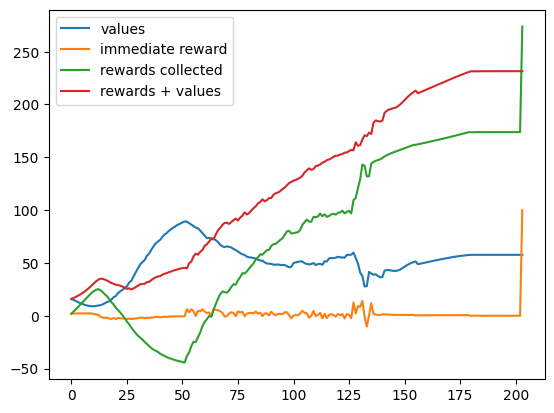

np.float64(273.8623111876872)

In [211]:
evaluate(network, stochastic=True, render_mode='human', graph=True)

In [212]:
print(list(network.g1.parameters()))  # for prelu
print(list(network.g2.parameters()))

[]
[]


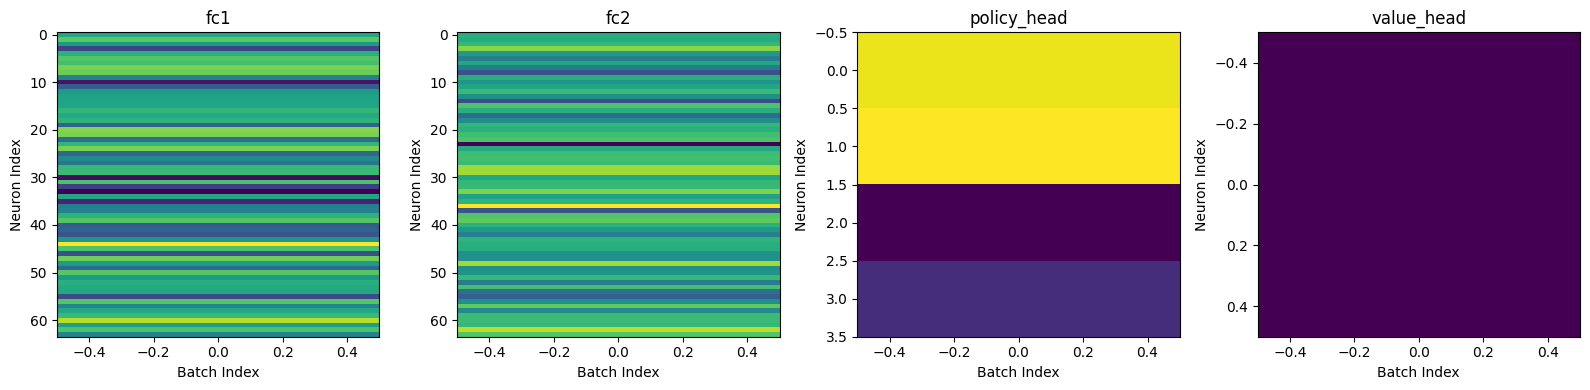

fc1 [ 0.539691  1.175566  0.295779 -1.229914  0.702287  1.127923  0.962652
  1.421259  1.317758 -0.191120 -1.883826 -0.788968  0.282480  0.438021
  0.452892  0.506639  0.799696  0.585076  0.752114 -0.700878  1.505089
  1.411699 -0.532699  0.789569  1.417185 -0.667549 -0.004287 -0.411854
  0.839035  0.896528 -1.999547  1.034287 -1.291082 -2.120607  0.510293
 -1.676283 -0.218482 -0.183413  0.741788  1.128517 -0.836619 -0.702855
 -0.937773  0.207851  2.304274  1.058239 -1.016454  1.332742  0.280184
 -0.611991  1.139585  0.285317  0.648578  0.576448  0.555111 -1.091455
  1.113720 -0.095809  0.554444  0.863845  1.831734  0.385772  1.059337
 -0.129130]
fc2 [ -2.282971  -2.600139  -1.094724   3.677897  -5.090747  -8.738877
  -3.133336  -9.152798 -14.102837  -2.179009  -5.613461  -3.392790
  -0.654182  -6.328395 -14.606815   0.520717  -2.375417 -10.773468
  -6.613972  -1.297754  -2.077740  -0.326749   0.579532 -21.885275
  -2.822437  -0.459772  -0.180859  -0.663682   4.733888   4.832385
  -3.3

In [213]:
def plot_activations(model, x, print_=True):
    activations = {}
    def hook_fn(module, inp, out, name):
        activations[name] = out.detach().cpu().numpy()
    hooks = []
    for name, layer in model.named_children():
        if isinstance(layer, torch.nn.Linear):  # capture only linear layers
            hooks.append(layer.register_forward_hook(lambda m, inp, out, n=name: hook_fn(m, inp, out, n)))
    with torch.no_grad():
        model(x)
    for hook in hooks:
        hook.remove()
    num_plots = len(activations)
    fig, axes = plt.subplots(1, num_plots, figsize=(4 * num_plots, 4))
    if num_plots == 1:
        axes = [axes]
    sout = ''
    for ax, (name, act) in zip(axes, activations.items()):
        sout += name + ' ' + str(act) + '\n'
        if act.ndim == 1:
            act = act.reshape(1, -1)
        ax.imshow(act.T, aspect='auto', cmap='viridis')
        ax.set_title(name)
        ax.set_xlabel('Batch Index')
        ax.set_ylabel('Neuron Index')
        # fig.colorbar(None, ax=ax, orientation='vertical')  # doesnt work negatives
    plt.tight_layout()
    plt.show()
    if print_: print(sout)

state, _ = env.reset()
state = torch.as_tensor(state, dtype=torch.float)
plot_activations(network, state)  # doesnt work directly with compile, OK

In [214]:
import os
os.makedirs('./saved', exist_ok=True)
torch.save(network.state_dict(), f'./saved/{env_name}-discrete-actor-critic.pth')
print('saved.')

saved.
